In [20]:
!pip install git+https://github.com/google-research/torchsde.git

  Cloning https://github.com/google-research/torchsde.git to /tmp/pip-req-build-z_qijmjv
  Running command git clone -q https://github.com/google-research/torchsde.git /tmp/pip-req-build-z_qijmjv
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 25.9MB 115kB/s 
     |████████████████████████████████| 174kB 46.3MB/s 
  Created wheel for torchsde: filename=torchsde-0.2.4-cp36-none-any.whl size=55585 sha256=7f5f880eb681c4e27fe30f3374d0c952314d034caf2a8a2bee78c48c6f6d6b10
  Stored in directory: /tmp/pip-ephem-wheel-cache-z982jqn8/wheels/31/b5/4b/53c7d7c124c1bbfebd2c5f429ca86b5e59f6cd4718dc0f1229
Successfully built torchsde
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [1]:
!pip install git+https://github.com/patrick-kidger/torchcde.git

  Cloning https://github.com/patrick-kidger/torchcde.git to /tmp/pip-req-build-14g1y19i
  Running command git clone -q https://github.com/patrick-kidger/torchcde.git /tmp/pip-req-build-14g1y19i
  Created wheel for torchcde: filename=torchcde-0.1.0-cp36-none-any.whl size=26752 sha256=d7e6b67fab0ffb8f8974e5322dd0840635c70a996e6f90b0b8647e7ecca35e66
  Stored in directory: /tmp/pip-ephem-wheel-cache-qocuafpu/wheels/27/70/62/fcc2954fe81b4263df3751dbd62599080933abee0a3f4736b4
Successfully built torchcde


In [2]:
!git clone 'https://github.com/crispitagorico/Signature-Kernel.git'

%cd /content/Signature-Kernel/src/ 

!python setup.py build_ext --inplace

/content/Signature-Kernel/notebooks


In [1]:
%cd /content/Signature-Kernel/notebooks/

/content/Signature-Kernel/notebooks


In [2]:
import base

import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import datetime
import pandas_datareader as pdr

import torchcde
import torchsde

# import signatory

from sigMMD import SigMMD, hypothesis_test

In [3]:
# ^GSPC is S&P 500.
ticker = "^GSPC"

start = datetime.date(2000, 1, 1)
end = datetime.date(2019, 1, 1)
freq = 'M'

data = pdr.get_data_yahoo(ticker, start, end)["Close"]

In [4]:
length = 15

In [5]:
returns = []
for _, dat in data.resample(freq):
    path = dat.values / dat.values[0]
    path = path[:length]
    # m = length - len(path)
    # path = np.pad(path, m, 'edge')[m:]
    path = np.c_[np.linspace(0.,1.,length), path]
    returns.append(path)

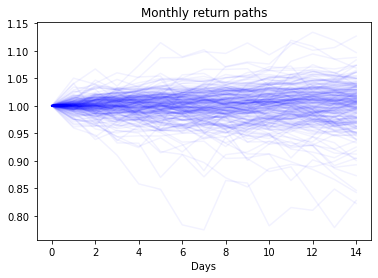

In [6]:
for ret_path in returns:
    plt.plot(ret_path[:,1], "b", alpha=0.05)

plt.title("Monthly return paths")
plt.xlabel("Days")
plt.show()

In [7]:
# data to generate
y_data = torch.stack([torch.tensor(r) for r in returns]).float()

In [8]:
num_samples = y_data.shape[0]

In [9]:
# time grid
times = torch.linspace(0., 1., length)

# Brownian motion simulator
bm = torchsde.BrownianInterval(t0=0., t1=1., size=(num_samples, 1))

# generate sample increments from Brownian motion 
bm_increments = torch.stack([bm(t0, t1) for t0, t1 in zip(times[:-1], times[1:])], dim=0)

# generate sample paths from Brownian motion
bm_paths = torch.cat((torch.zeros(1, num_samples, 1), torch.cumsum(bm_increments, dim=0)))
bm_paths = bm_paths.permute(1,0,2)

# include time as a channel
times_ =  times.unsqueeze(0).unsqueeze(-1).expand(num_samples, length, 1)
x_data = torch.cat([times_, bm_paths], dim=2)  

In [32]:
torch.save(x_data, '../data/S&P_500_x_data.pt')
torch.save(y_data, '../data/S&P_500_y_data.pt')

In [11]:
# x_data = torch.load('../data/S&P_500_x_data.pt')
# y_data = torch.load('../data/S&P_500_y_data.pt')

In [12]:
class VectorField(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, inner_dim=32):
        ######################
        # input_dim is the number of input channels in the data X. (Determined by the data.)
        # hidden_dim is the number of channels for z_t. (Determined by you.)
        ######################
        super(VectorField, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.linear1 = torch.nn.Linear(hidden_dim, inner_dim)
        self.linear2 = torch.nn.Linear(inner_dim, inner_dim)
        self.linear3 = torch.nn.Linear(inner_dim, input_dim * hidden_dim)

    ######################
    # The t argument is not used here; it can be used when you want your CDE to behave differently at different times.
    ######################
    def forward(self, t, z):

        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        # z = self.linear2(z)
        # z = z.relu()
        z = self.linear3(z)
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_dim, self.input_dim)
        return z

In [13]:
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        super(NeuralCDE, self).__init__()

        self.func = VectorField(input_dim, hidden_dim)

        self.initial = torch.nn.Linear(input_dim, hidden_dim)
        self.readout = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # x, t = torchcde.logsignature_windows(x, depth=2, window_length=5)

        coeffs = torchcde.linear_interpolation_coeffs(x)
        # coeffs = linear_interpolation_coeffs(X_input, rectilinear=0)
        X = torchcde.LinearInterpolation(coeffs)

        # coeffs = torchcde.natural_cubic_coeffs(x)
        # X = torchcde.NaturalCubicSpline(coeffs)
        
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)

        z = torchcde.cdeint(X=X, 
                            func=self.func, 
                            z0=z0, 
                            t=X.grid_points,
                            method='dopri5', 
                            options=dict(grid_points=X.grid_points, eps=1e-5)
                            )

        y = self.readout(z)
        return y

In [14]:
model = NeuralCDE(input_dim=2, hidden_dim=8, output_dim=2)
# model = NeuralCDE(input_dim=signatory.logsignature_channels(3,2), hidden_dim=8, output_dim=2)

In [15]:
x_train = x_data[50:].cuda()
y_train = y_data[50:].cuda()
x_test = x_data[:50].cuda()
y_test = y_data[:50].cuda()

model = model.cuda()

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

In [18]:
criterion = SigMMD(n=2, solver=2)
# criterion = torch.nn.MSELoss()

In [19]:
losses = []

In [20]:
num_epochs = 100

for epoch in range(num_epochs):

    for batch in train_dataloader:
        x, y = batch
        pred_y = model(x)
        loss = criterion(pred_y, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    losses.append(loss.item())
    
    if epoch%10==0:
        model.eval()
        with torch.no_grad():
            y_pred = model(x_test)
            test_loss = criterion(y_pred, y_test)
        print('Epoch: {}   Training loss: {}   Test loss: {}'.format(epoch, loss.item(), test_loss.item()))
        model.train()

Epoch: 0   Training loss: 1.1395418643951416   Test loss: 0.9634084701538086
Epoch: 10   Training loss: 0.002726700622588396   Test loss: 0.0036227558739483356
Epoch: 20   Training loss: 0.00040979738696478307   Test loss: 0.0009306182619184256
Epoch: 30   Training loss: 0.00014639942673966289   Test loss: 0.0002245946234324947


KeyboardInterrupt: ignored

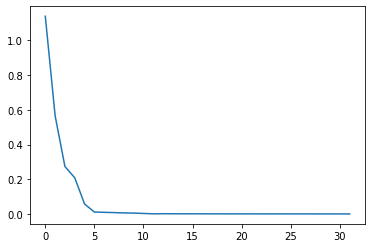

In [21]:
plt.plot(losses)
plt.show()

In [22]:
y_pred = model(x_test)

In [23]:
y_pred_ = y_pred.cpu().detach().numpy()
y_test_ = y_test.cpu().detach().numpy()

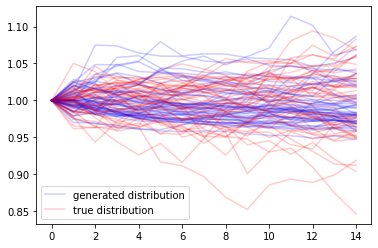

In [28]:
for k in range(50):
    plt.plot(y_pred_[k][:,1], 'b', alpha=0.2, label='generated distribution' if k==0 else '')
    plt.plot(y_test_[k][:,1], 'r', alpha=0.2, label='true distribution' if k==0 else '')
plt.legend()
plt.show()

In [29]:
y_pred_ = y_pred.cpu().detach().double()
y_test_ = y_test.cpu().detach().double()

In [30]:
hypothesis_test(y_pred_, y_test_, n=2, solver=1)

Hypothesis accepted: distribution are equal with 99.0% confidence
